<a href="https://colab.research.google.com/github/Sylvariane/detection_faux_billets/blob/master/P06_01_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Création d'un algorithme de détection de billets

## 0. Paramétrage de l'environnement

In [ ]:
# connexion à Google Drive pour importer les dossiers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Liste des librairies importées
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
########################
##FONCTIONS DE CALCULS##
########################

def eta_squared(x,y):
  """Fonction qui calcule l'effet de la taille dans le cadre d'une ANOVA à un facteur
  Entrées : 
  - une variable catégorielle x,
  - une variable quantitative y.

  Sortie :
  - résultat de l'eta-carré
  """
  moyenne_y = y.mean()
  classes = []
  for classe in x.unique():
    yi_classe = y[x==classe]
    classes.append({'ni': len(yi_classe),
                    'moyenne_classe': yi_classe.mean()})
  SCT = sum([(yj-moyenne_y)**2 for yj in y])
  SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
  return SCE/SCT

def distrib_normalize(i):
  """Fonction qui trace la distribution d'une variable et qui calcule la symétrie, 
  le coefficient d'applatissement et le respect à une loi statistique : ici la loi normale
  Entrée : 
  - Colonne d'une variable

  Sortie : 
  - Graphique de distribution
  - Résultat de la symétrie
  - Résultat du coefficient d'applatissement
  - Résultat à l'adéquation à la loi normale
  """
  print(i.capitalize())
  _ = sns.displot(data[i])
  _ = plt.axvline(x=data[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
  _ = plt.axvline(x=data[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
  _ = plt.show()
  print('Skewness: ', str(st.stats.skew(data[i])))
  print('Kurtosis: ', str(st.stats.kurtosis(data[i])))
  print(str(ks_2samp(data[i],list(np.random.normal(np.mean(data[i]), np.std(data[i]), 1000)))))

########################
##FONCTIONS DE DESSINS##
########################

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
  """
  Fonction qui trace le cercle de corrélation de l'ACP

  Entrées : 
  - Coordonnées des points de l'ACP
  - Nombre de composantes
  - Fonction de l'ACP dans sklearn
  - Composantes que l'on souhaite représenter

  Sortie : 
  - Cercle de corrélation  
  """
  for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
      if d2 < n_comp:

          # initialisation de la figure
          fig, ax = plt.subplots(figsize=(10,10))

          # détermination des limites du graphique
          if lims is not None :
              xmin, xmax, ymin, ymax = lims
          elif pcs.shape[1] < 30 :
              xmin, xmax, ymin, ymax = -1, 1, -1, 1
          else :
              xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

          # affichage des flèches
          # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
          if pcs.shape[1] < 30 :
              plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                pcs[d1,:], pcs[d2,:], 
                angles='xy', scale_units='xy', scale=1, color="grey")
              # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
          else:
              lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
              ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
          # affichage des noms des variables  
          if labels is not None:  
              for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                  if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
          # affichage du cercle
          an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
          plt.plot(np.cos(an), np.sin(an))
          plt.axis('equal')

          # définition des limites du graphique
          plt.xlim(xmin, xmax)
          plt.ylim(ymin, ymax)
        
          # affichage des lignes horizontales et verticales
          plt.plot([-1, 1], [0, 0], color='grey', ls='--')
          plt.plot([0, 0], [-1, 1], color='grey', ls='--')

          # nom des axes, avec le pourcentage d'inertie expliqué
          plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
          plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

          plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
          plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
  """Fonction qui trace la représentation des individus sur les plans factoriels

  Entrées :
  - Individus projetés
  - Nombre de composante
  - Fonction de l'ACP issue de Sklearn
  - Composantes que l'on souhaite représenter
  - Variables illustratives

  Sortie : 
  - Projection des individus sur les composantes sélectionnées
  """
  for d1,d2 in axis_ranks:
    if d2 < n_comp:
      # initialisation de la figure       
      fig = plt.figure(figsize=(7,6))
        
      # affichage des points
      if illustrative_var is None:
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
      else:
        illustrative_var = np.array(illustrative_var)
      for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
      plt.legend()

      # affichage des labels des points
      if labels is not None:
        for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
          plt.text(x, y, labels[i],
          fontsize='14', ha='center',va='center') 
                
      # détermination des limites du graphique
      boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
      plt.xlim([-boundary,boundary])
      plt.ylim([-boundary,boundary])
        
      # affichage des lignes horizontales et verticales
      plt.plot([-100, 100], [0, 0], color='grey', ls='--')
      plt.plot([0, 0], [-100, 100], color='grey', ls='--')

      # nom des axes, avec le pourcentage d'inertie expliqué
      plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
      plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

      plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
      plt.show(block=False)

In [ ]:
# paramétrage de l'environnement graphique
sns.set_context('talk')
sns.set_palette('Set2')

In [ ]:
# Chargement du dataset pour analyses et construction de l'algorithme
data = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P6_guillot_cecile/notes.csv')

## 1. Visualisation du dataset et nettoyages préalables

In [ ]:
# Constitution du dataset
print(data.head())
data.shape

   is_genuine  diagonal  height_left  ...  margin_low  margin_up  length
0        True    171.81       104.86  ...        4.52       2.89  112.83
1        True    171.67       103.74  ...        4.01       2.87  113.29
2        True    171.83       103.76  ...        4.40       2.88  113.84
3        True    171.80       103.78  ...        3.73       3.12  113.63
4        True    172.05       103.70  ...        5.04       2.27  113.55

[5 rows x 7 columns]


(170, 7)

Le dataset est composé de sept colonnes et de 170 lignes. Parmi les colonnes, on retrouve une colonne de type booléen (is_genuine) et 6 colonnes de numérique (float).

In [ ]:
# Recherche des valeurs manquantes
print('Valeurs manquantes :\n' + str(data.isnull().sum()))

Valeurs manquantes :
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


Le jeu de données ne dispose pas de valeurs manquantes.

In [ ]:
# Recherche des valeurs dupliquées
print('Valeurs dupliquées : ', data.duplicated().sum())

Valeurs dupliquées :  0


On ne retrouve pas de valeurs dupliquées dans nos données. 

## 2. Analyses descriptives

**Mission 0** : Afin d'introduire votre analyse, effectuez une brève description des données (analyses univariées et bivariées).



In [ ]:
description = data.groupby('is_genuine').describe().T
print(description)

is_genuine               False       True 
diagonal     count   70.000000  100.000000
             mean   171.889857  171.976100
             std      0.297426    0.307981
             min    171.380000  171.040000
             25%    171.682500  171.790000
             50%    171.875000  172.005000
             75%    172.047500  172.162500
             max    173.010000  172.750000
height_left  count   70.000000  100.000000
             mean   104.230429  103.951500
             std      0.213130    0.296251
             min    103.780000  103.230000
             25%    104.082500  103.740000
             50%    104.215000  103.915000
             75%    104.377500  104.145000
             max    104.720000  104.860000
height_right count   70.000000  100.000000
             mean   104.145571  103.775900
             std      0.253152    0.292406
             min    103.440000  103.140000
             25%    103.982500  103.557500
             50%    104.170000  103.760000
           

Notre échantillon contient 170 billets : 100 vrais billets et 70 faux.

*Portrait-robot du vrai billet :* 
- Hauteur mesurée à gauche : 103.95 mm, 
- Hauteur mesurée à droite : 103.77 mm, 
- Marge entre le bord supérieur et le bord de l'image : 4.14 mm, 
- Marge entre le bord inférieur et le bord de l'image : 3.05mm 
- Longueur : 113.20 mm, 
-  Diagonale : 171.97 mm.

In [ ]:
data_true = data.loc[data['is_genuine']==True][['height_left', 'height_right']]
data_true = np.array(data_true)

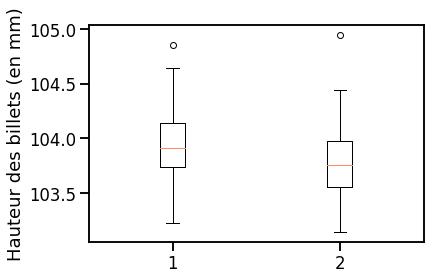

In [ ]:
plt.boxplot(data_true)
plt.ylabel('Hauteur des billets (en mm)')
plt.show()

In [ ]:
right = data.loc[data['is_genuine']==True]['height_right']
left = data.loc[data['is_genuine']==True]['height_left']
print('Test de Bartlett :', st.stats.bartlett(right,left))
print('Test de Welsch :', st.stats.ttest_ind(right,left, equal_var=False))

Test de Bartlett : BartlettResult(statistic=0.01680747422468568, pvalue=0.8968483723173337)
Test de Welsch : Ttest_indResult(statistic=-4.218599950470179, pvalue=3.7401450713826616e-05)


In [ ]:
data_true = data.loc[data['is_genuine']==True][['margin_up', 'margin_low']]
data_true = np.array(data_true)

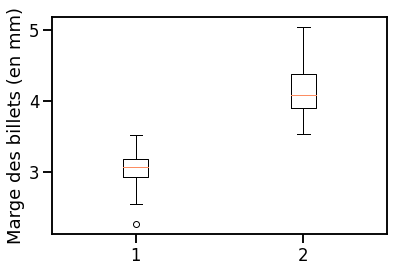

In [ ]:
plt.boxplot(data_true)
plt.ylabel('Marge des billets (en mm)')
plt.show()

In [ ]:
low=data.loc[data['is_genuine']==True]['margin_low']
up=data.loc[data['is_genuine']==True]['margin_up']
print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(low, up))

Test de Mann-Whitney :  MannwhitneyuResult(statistic=0.0, pvalue=1.2696477302848506e-34)


In [ ]:
data_true = data.loc[data['is_genuine']==True][['diagonal', 'length']]
data_true = np.array(data_true)

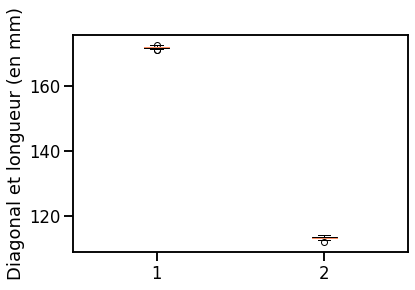

In [ ]:
plt.boxplot(data_true)
plt.ylabel('Diagonal et longueur (en mm)')
plt.show()

*Portrait-robot du faux billet :* 
- Hauteur mesurée sur le côté gauche : 104.23 mm, 
- Hauteur mesurée sur le côté droit : 104.15 mm, 
- Marge entre le bord supérieur et le bord de l'image : 5.28 mm, 
- Marge entre le bord inférieur et le bord de l'image : 3.33 mm,
- Longueur : 111.66 mm,
- Diagonale : 171.88 mm.

In [ ]:
data_false = data.loc[data['is_genuine']==False][['height_left', 'height_right']]
data_false = np.array(data_false)

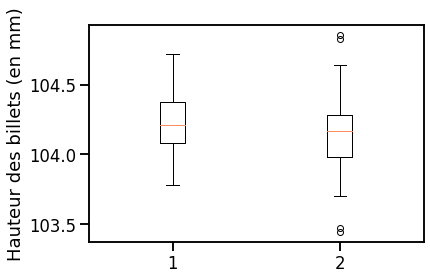

In [ ]:
plt.boxplot(data_false)
plt.ylabel('Hauteur des billets (en mm)')
plt.show()

In [ ]:
right = data.loc[data['is_genuine']==False]['height_right']
left = data.loc[data['is_genuine']==False]['height_left']
print('Test de Bartlett :', st.stats.bartlett(right,left))
print('Test de Welsch :', st.stats.ttest_ind(right,left, equal_var=False))

Test de Bartlett : BartlettResult(statistic=2.0187248920646925, pvalue=0.1553695635519479)
Test de Welsch : Ttest_indResult(statistic=-2.145407712749294, pvalue=0.033721795315926305)


In [ ]:
data_false = data.loc[data['is_genuine']==False][['margin_up', 'margin_low']]
data_false = np.array(data_false)

In [ ]:
low=data.loc[data['is_genuine']==False]['margin_low']
up=data.loc[data['is_genuine']==False]['margin_up']
print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(low, up))

Test de Mann-Whitney :  MannwhitneyuResult(statistic=0.0, pvalue=9.04407242106181e-25)


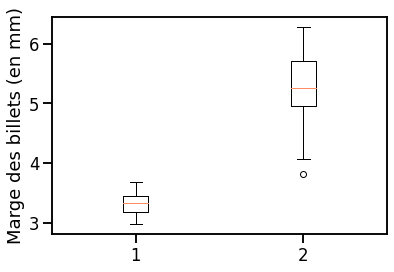

In [ ]:
plt.boxplot(data_false)
plt.ylabel('Marge des billets (en mm)')
plt.show()

In [ ]:
data_false = data.loc[data['is_genuine']==False][['diagonal', 'length']]
data_false = np.array(data_false)

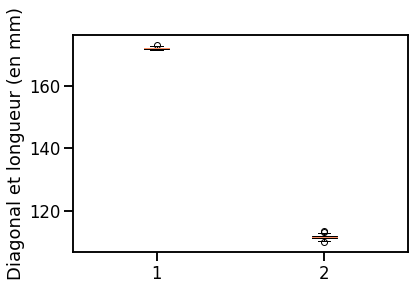

In [ ]:
plt.boxplot(data_false)
plt.ylabel('Diagonal et longueur (en mm)')
plt.show()

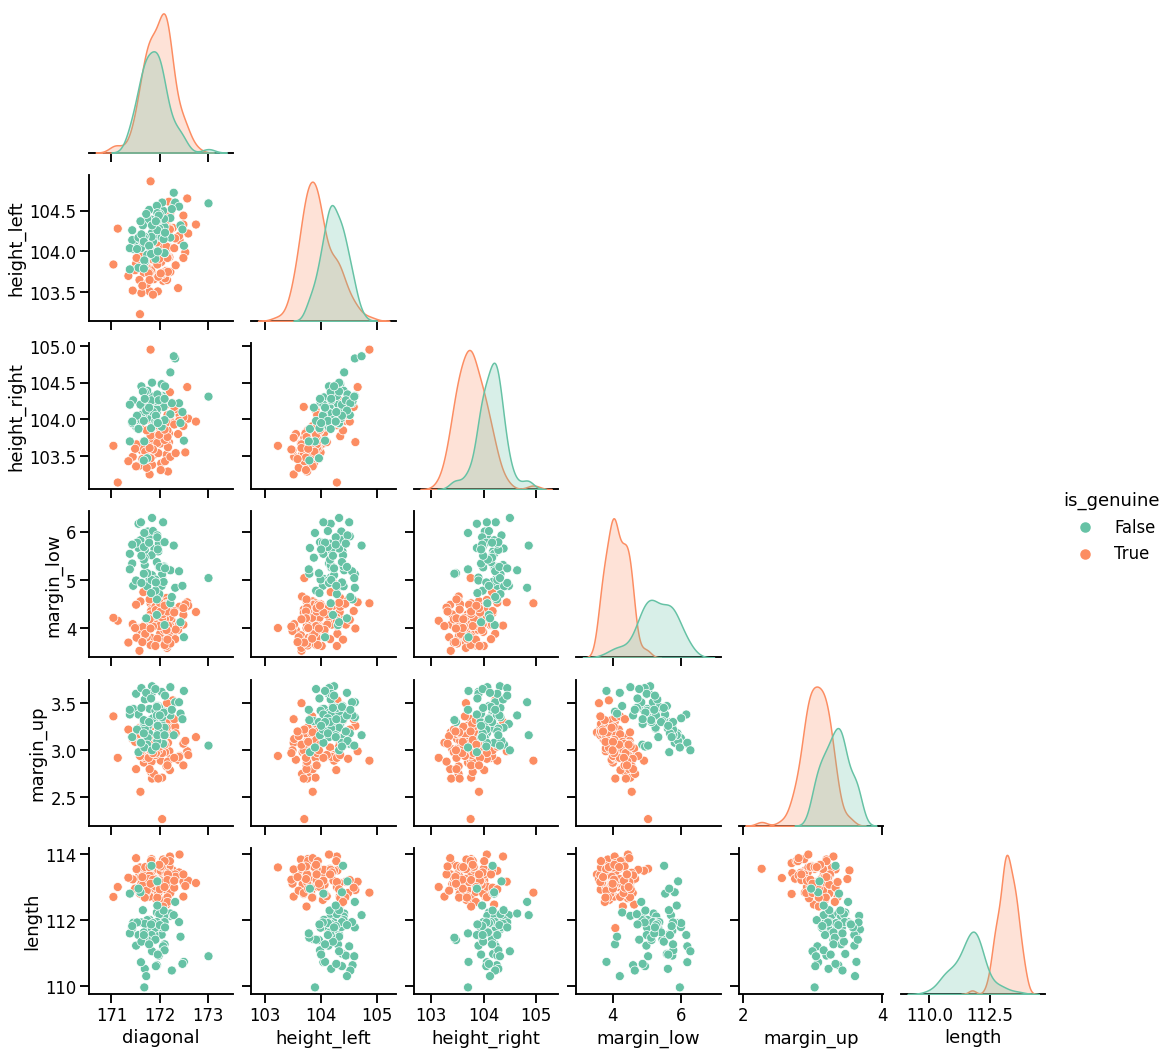

In [ ]:
_ = sns.pairplot(data, hue='is_genuine', corner=True)
_ = plt.show()

Diagonal


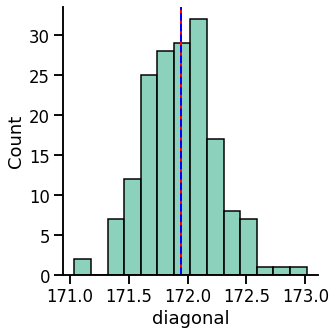

Skewness:  0.19443137121477527
Kurtosis:  0.5346375075188288
Ks_2sampResult(statistic=0.05282352941176471, pvalue=0.7897559717004516)
Height_left


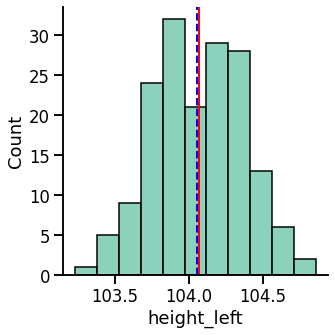

Skewness:  0.02839494808973424
Kurtosis:  -0.4833327619035872
Ks_2sampResult(statistic=0.05452941176470588, pvalue=0.7571385104552336)
Height_right


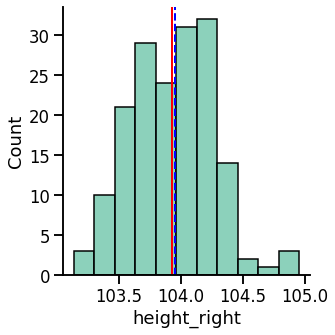

Skewness:  0.16739211723354264
Kurtosis:  -0.03982952213509616
Ks_2sampResult(statistic=0.05823529411764706, pvalue=0.6831756402302108)
Margin_low


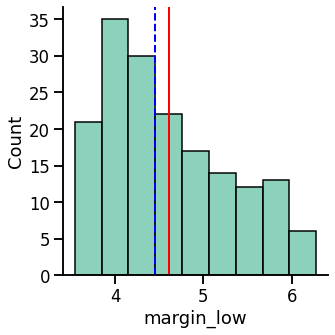

Skewness:  0.5796855414374862
Kurtosis:  -0.75717722821391
Ks_2sampResult(statistic=0.10170588235294117, pvalue=0.09165652278899661)
Margin_up


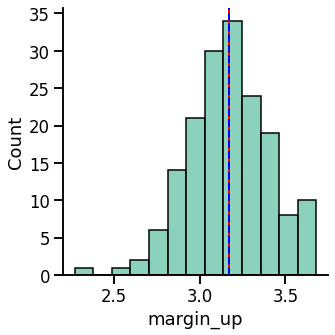

Skewness:  -0.2025055216127945
Kurtosis:  0.49813176957106853
Ks_2sampResult(statistic=0.04411764705882353, pvalue=0.9264157479997126)
Length


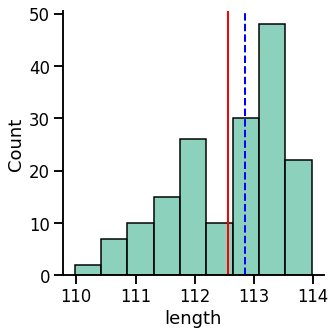

Skewness:  -0.6506712141894133
Kurtosis:  -0.5531969324412676
Ks_2sampResult(statistic=0.14635294117647057, pvalue=0.0034955581631900268)


In [ ]:
cols = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
    distrib_normalize(i)

Seulement deux variables ne vont pas suivre la loi normale : margin_low et length. 

In [ ]:
x = data['margin_up']
y = data['margin_low']

print('rho de pearson :', st.stats.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = data['margin_low']
X = data[['margin_up']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['margin_up'],result.params['intercept']
print('r-squared : ', (st.stats.pearsonr(x,y)[0])**2)

rho de pearson : 0.17111283050073073
indice de covariation : 0.028229128027681665
r-squared :  0.029279600761971804


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


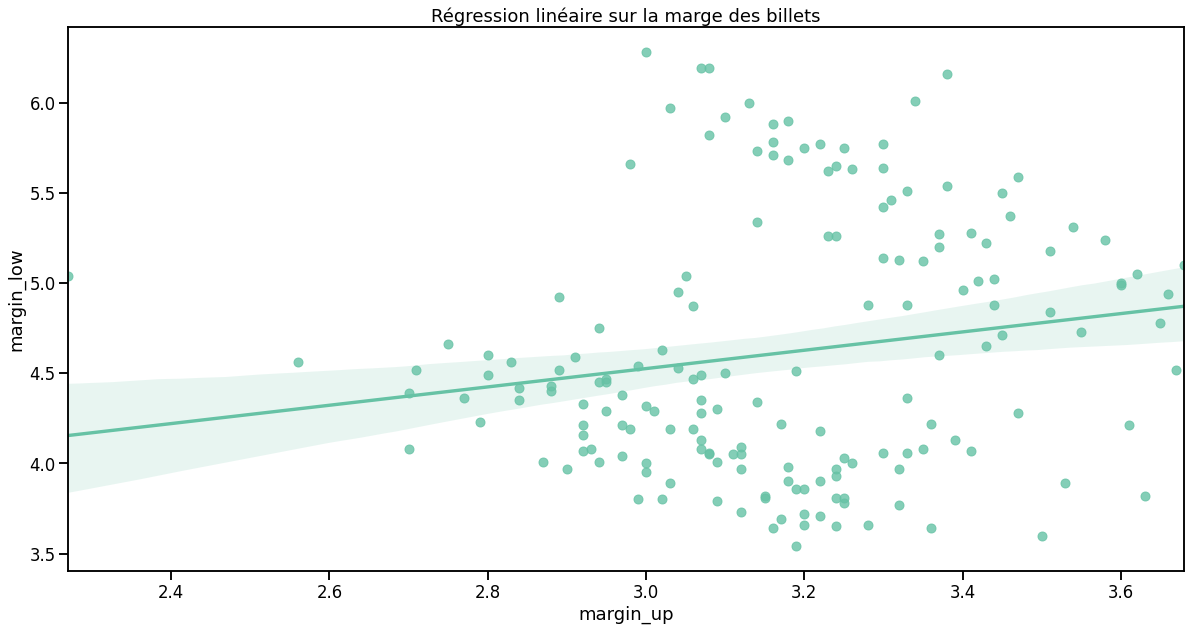

In [ ]:
plt.figure(figsize=(20,10))
sns.regplot(x, y, fit_reg=True)
plt.title('Régression linéaire sur la marge des billets')
plt.show()

In [ ]:
x = data['height_right']
y = data['height_left']

print('rho de pearson :', st.stats.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = data['height_left']
X = data[['height_right']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['height_right'],result.params['intercept']
print('r-squared : ', (st.stats.pearsonr(x,y)[0])**2)

rho de pearson : 0.7343902682297875
indice de covariation : 0.07205313494809684
r-squared :  0.5393290660706193


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


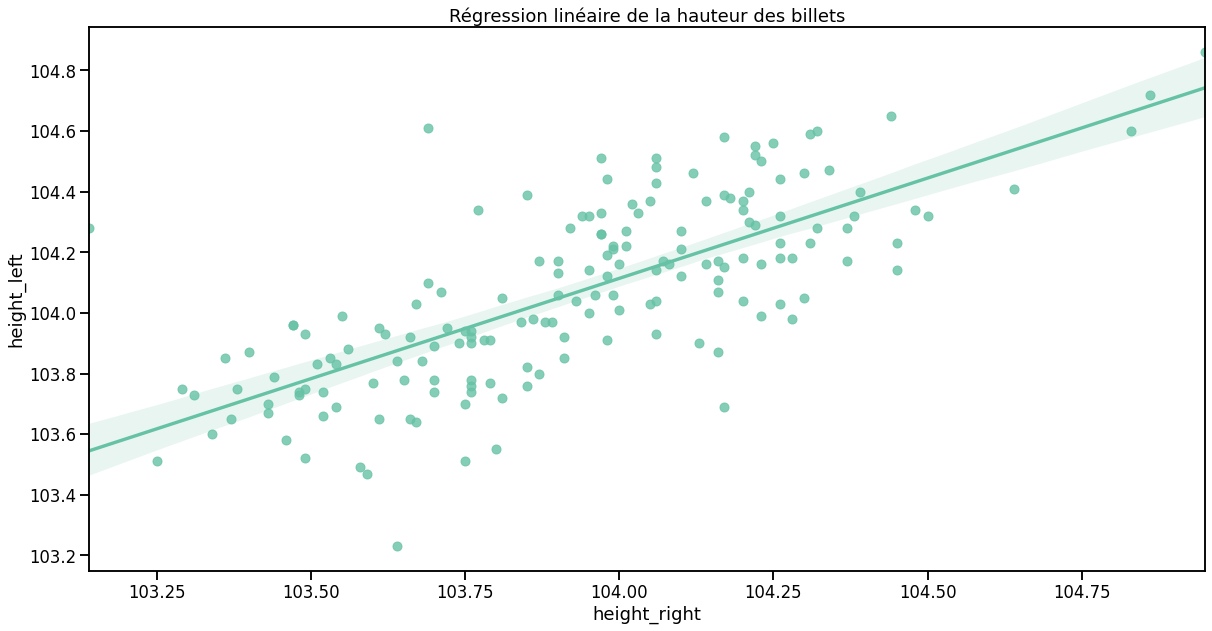

In [ ]:
plt.figure(figsize=(20,10))
sns.regplot(x, y, fit_reg=True)
plt.title('Régression linéaire de la hauteur des billets')
plt.show()

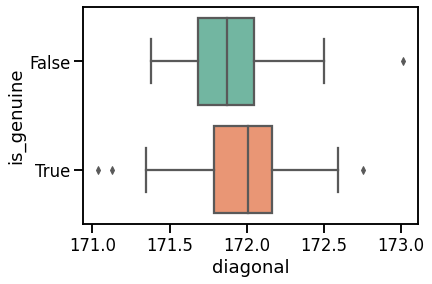

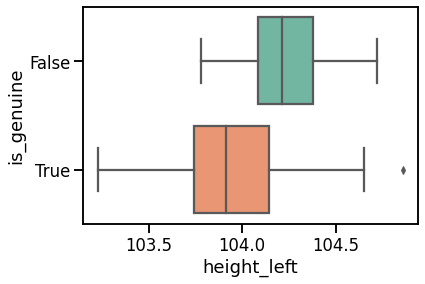

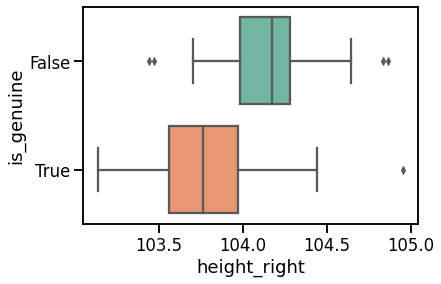

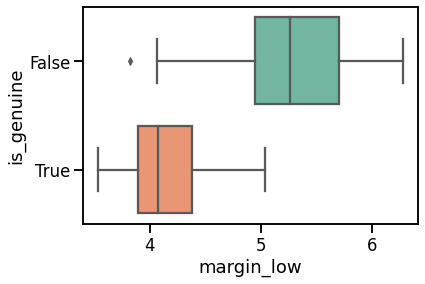

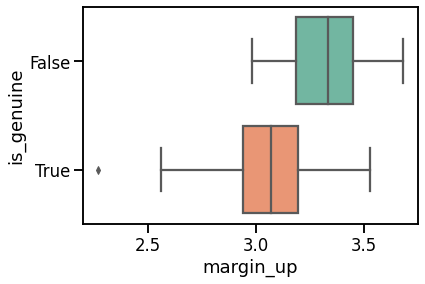

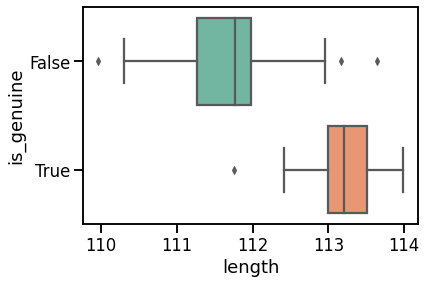

In [ ]:
for i in cols: 
    _ = sns.boxplot(x=i, y='is_genuine', data=data, orient='h')
    _ = plt.show()

In [ ]:
for i in cols:
    print(i.capitalize())
    X = data['is_genuine'] # qualitative
    Y = data[i] # quantitative
    print('eta-squared :', eta_squared(X,Y))

Diagonal
eta-squared : 0.019383108567093802
Height_left
eta-squared : 0.21319458315018705
Height_right
eta-squared : 0.30394154672012125
Margin_low
eta-squared : 0.640177214288775
Margin_up
eta-squared : 0.3396567096032002
Length
eta-squared : 0.6818507654957807


In [ ]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right','margin_up']]

for i in cols:
    true = data.loc[data['is_genuine'] == True][i]
    false = data.loc[data['is_genuine'] == False][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(true, false))
    elif i in cols_1:
        print('Test de Bartlett :', st.stats.bartlett(true,false))
        print('Test de Student :', st.stats.ttest_ind(true,false, equal_var=True))
    else:
        print('Test de Bartlett :', st.stats.bartlett(true,false))
        print('Test de Welsch :', st.stats.ttest_ind(true,false, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.09785668979597505, pvalue=0.7544170098956573)
Test de Student : Ttest_indResult(statistic=1.8222865515506024, pvalue=0.07018967008887296)
Height_left
Test de Bartlett : BartlettResult(statistic=8.294302164373534, pvalue=0.003976965959594022)
Test de Welsch : Ttest_indResult(statistic=-7.138967397007879, pvalue=2.7083988500085442e-11)
Height_right
Test de Bartlett : BartlettResult(statistic=1.6456014709345594, pvalue=0.19955865324739466)
Test de Student : Ttest_indResult(statistic=-8.564989194564754, pvalue=6.665246409290165e-15)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=306.0, pvalue=2.44739545685913e-24)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.34879710746030196, pvalue=0.554794849415443)
Test de Student : Ttest_indResult(statistic=-9.295866009945723, pvalue=7.567386063614238e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=226.0, pvalue=1.7876766232996412e-25)


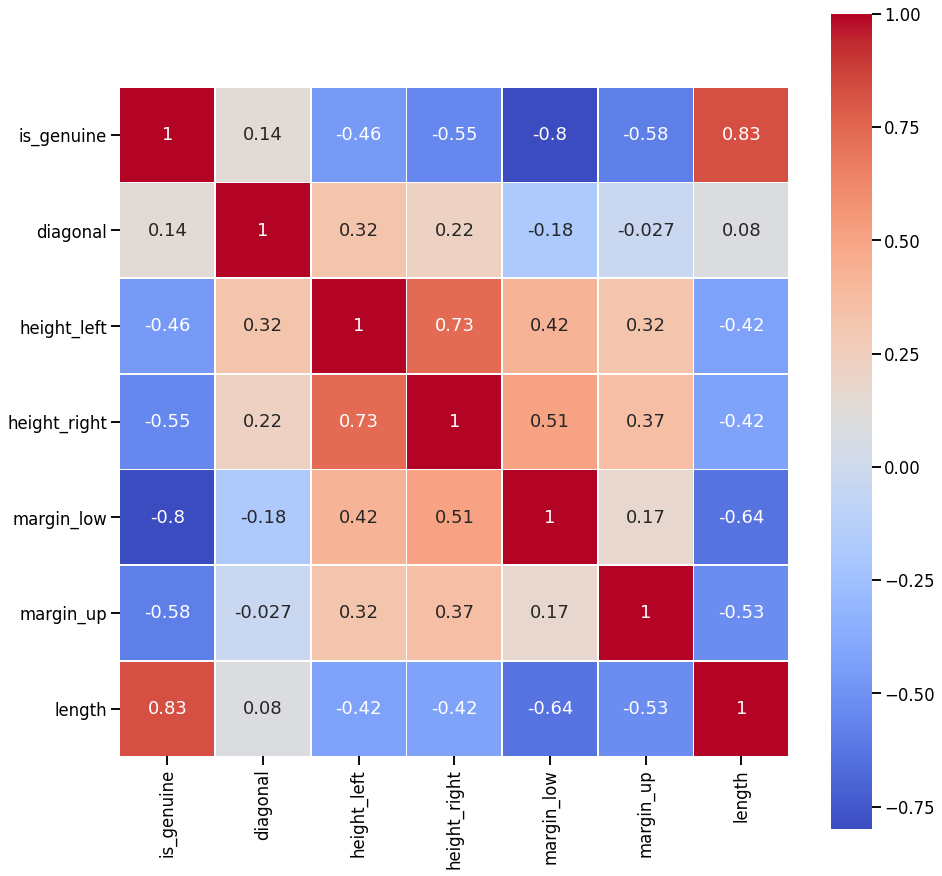

In [ ]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
_ = plt.show()

## 3. Analyse en composantes principales

**Mission 1** : Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :

- Analyse de l'éboulis des valeurs propres ;
- Représentation des variables par le cercle des corrélations ;
- Représentation des individus par les plans factoriels ;
- Analyse de la qualité de représentation et la contribution des individus.

Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

In [ ]:
data_acp = data.drop(columns='is_genuine')

print(data_acp.shape)
n = data_acp.shape[0]
p = data_acp.shape[1]

(170, 6)


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Z = sc.fit_transform(data_acp)

print(Z)

[[-0.42834385  2.6694537   3.09656321 -0.13159013 -1.18987367  0.28163308]
 [-0.88755932 -1.09769709 -0.69125444 -0.86012554 -1.27473985  0.78069736]
 [-0.36274164 -1.03042654 -0.50943919 -0.30301023 -1.23230676  1.37740465]
 ...
 [ 1.73652911  0.68497248  0.52084721  0.38267015  0.67718214 -2.05094997]
 [-0.39554274 -0.32408577 -0.1458087   0.16839504  1.61071005 -0.75989238]
 [ 0.06367273 -0.22317994  0.06630909  1.45404575  0.38015054 -1.74717171]]


In [ ]:
from sklearn.decomposition import PCA

acp = PCA()
print(acp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


In [ ]:
coord = acp.fit_transform(Z)
print(acp.n_components_)

6


In [ ]:
print(acp.explained_variance_)

[2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]


In [ ]:
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[2.84687523 1.31742636 0.85407146 0.51157773 0.27676935 0.19327987]


In [ ]:
ratio = acp.explained_variance_ratio_ * 100
print(acp.explained_variance_ratio_)

[0.47447921 0.21957106 0.14234524 0.08526295 0.04612822 0.03221331]


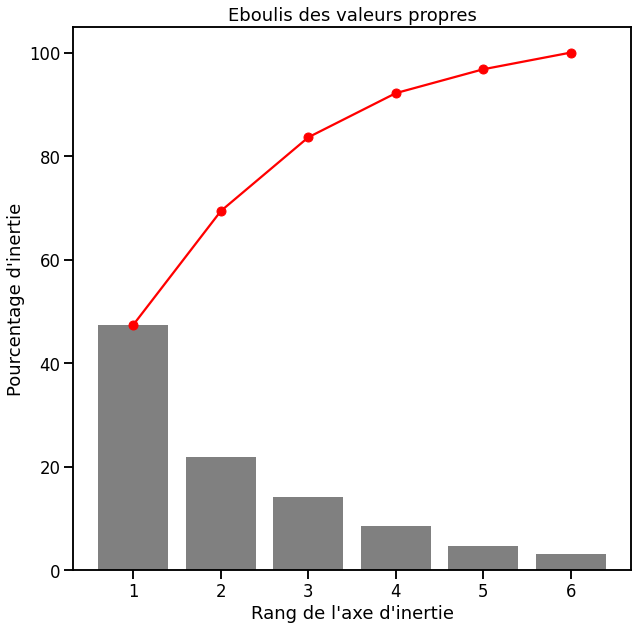

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

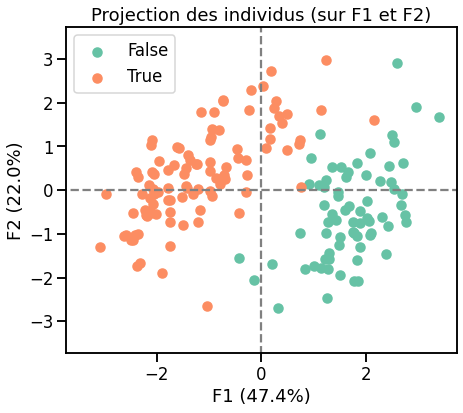

In [ ]:
display_factorial_planes(coord, p, acp, [(0,1)], illustrative_var=data['is_genuine'])

In [ ]:
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp.index,'d_i':di}))

      ID        d_i
0      0  18.410598
1      1   5.444799
2      2   4.960527
3      3   4.805719
4      4  18.039567
..   ...        ...
165  165   7.673233
166  166  20.625650
167  167   8.567410
168  168   3.482926
169  169   5.369633

[170 rows x 2 columns]


In [ ]:
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

print(pd.DataFrame({'id':data_acp.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

      id    COS2_1    COS2_2
0      0  0.251929  0.139000
1      1  0.818002  0.050822
2      2  0.784862  0.000466
3      3  0.882856  0.001652
4      4  0.320145  0.009417
..   ...       ...       ...
165  165  0.800651  0.004703
166  166  0.324059  0.411824
167  167  0.498809  0.083461
168  168  0.156908  0.271800
169  169  0.421817  0.217111

[170 rows x 3 columns]


In [ ]:
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j])
  
print(pd.DataFrame({'id':data_acp.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))

      id     CTR_1     CTR_2
0      0  0.009584  0.011426
1      1  0.009203  0.001236
2      2  0.008045  0.000010
3      3  0.008767  0.000035
4      4  0.011933  0.000759
..   ...       ...       ...
165  165  0.012694  0.000161
166  166  0.013811  0.037927
167  167  0.008830  0.003193
168  168  0.001129  0.004227
169  169  0.004680  0.005205

[170 rows x 3 columns]


In [ ]:
#le champs components_ de l'objet ACP
print(acp.components_)

[[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
 [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]
 [-0.08889419  0.12276016  0.15383022  0.5128076  -0.82114881  0.12691346]
 [-0.55973158  0.2780463   0.45893794 -0.22652773  0.13533955  0.57370304]
 [-0.22509444  0.71592059 -0.48699285 -0.31190784 -0.1939426  -0.25441684]
 [ 0.12216606  0.23213146 -0.4808135   0.54763041  0.35437971  0.52395111]]


In [ ]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs    
print(corvar)

[[ 0.1236346   0.89486346 -0.08215244 -0.40034612 -0.11841965  0.05370861]
 [ 0.80229967  0.38938864  0.11345001  0.19887167  0.37663775  0.10205336]
 [ 0.8298348   0.27035382  0.14216371  0.32825381 -0.25620145 -0.21138296]
 [ 0.72725782 -0.36790977  0.4739162  -0.16202319 -0.1640912   0.24075808]
 [ 0.59482939 -0.1619761  -0.75887278  0.09680115 -0.10203101  0.15579811]
 [-0.78520903  0.36102241  0.11728832  0.41033916 -0.13384583  0.23034781]]


In [ ]:
#on affiche pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

             id     COR_1     COR_2
0      diagonal  0.123635  0.894863
1   height_left  0.802300  0.389389
2  height_right  0.829835  0.270354
3    margin_low  0.727258 -0.367910
4     margin_up  0.594829 -0.161976
5        length -0.785209  0.361022


In [ ]:
data_acp.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

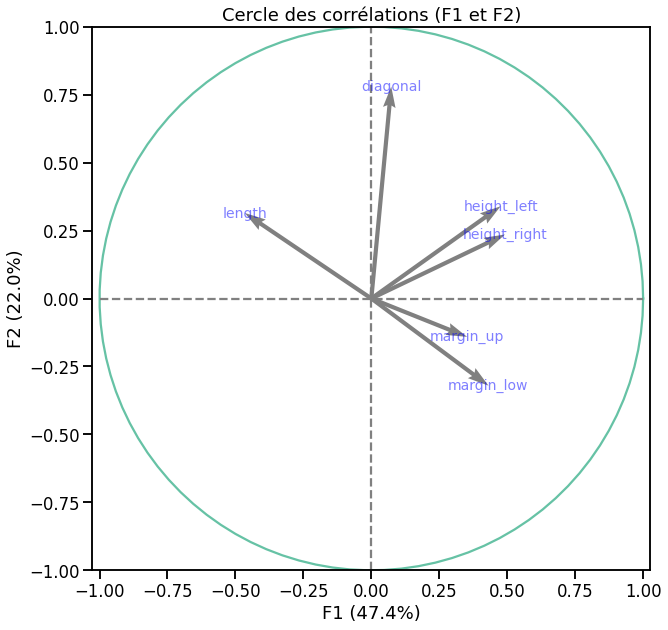

In [ ]:
pcs = acp.components_
features = data_acp.columns
display_circles(pcs, p, acp, [(0,1)], labels = np.array(features))

In [ ]:
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':data_acp.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

             id    COS2_1    COS2_2
0      diagonal  0.015286  0.800781
1   height_left  0.643685  0.151624
2  height_right  0.688626  0.073091
3    margin_low  0.528904  0.135358
4     margin_up  0.353822  0.026236
5        length  0.616553  0.130337


In [ ]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

             id     CTR_1     CTR_2
0      diagonal  0.005369  0.607837
1   height_left  0.226102  0.115091
2  height_right  0.241888  0.055480
3    margin_low  0.185784  0.102744
4     margin_up  0.124284  0.019915
5        length  0.216572  0.098933


## 4. Classification non supervisée

**Mission 2** : Appliquez un algorithme de classification, puis analysez le résultat obtenu.
Visualisez la partition obtenue dans le premier plan factoriel de l'ACP, puis analysez-la.

### 4.1. Classification hiérarchique : Dendrogramme

#### 4.1.1. Construction de la classification

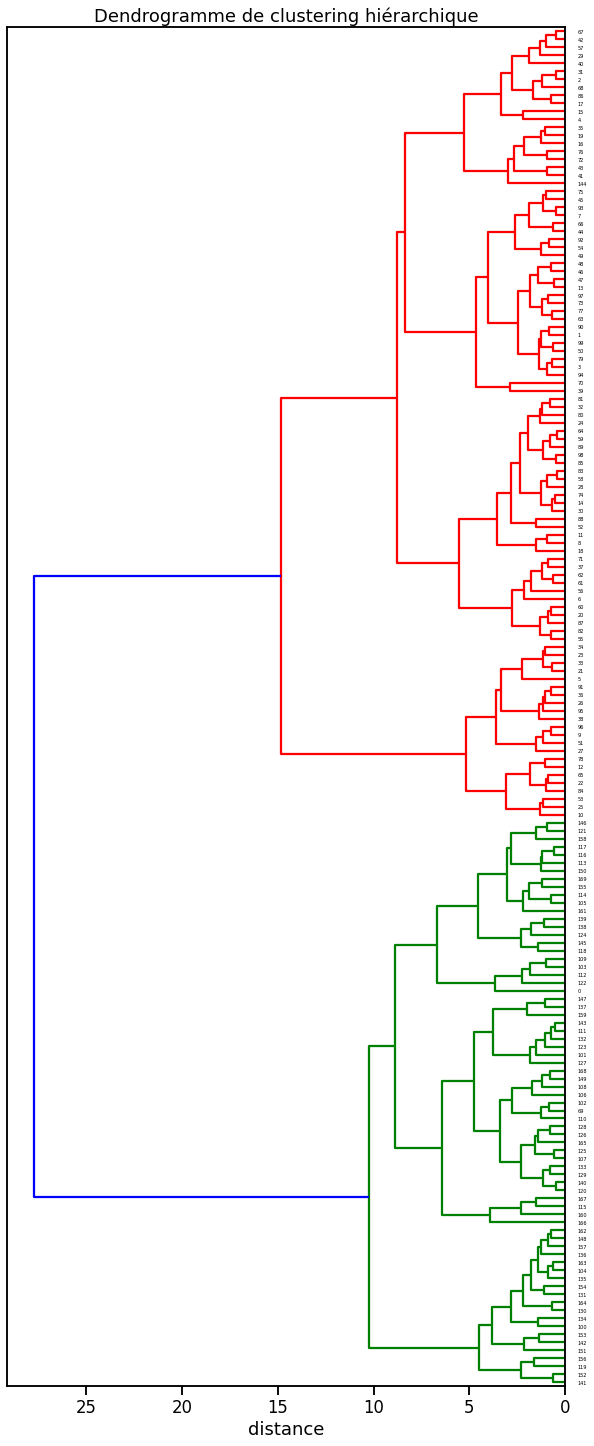

In [ ]:
# préparation des données pour le clustering
X = data_acp.values
names = data_acp.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(10,25))
plt.title('Dendrogramme de clustering hiérarchique')
plt.xlabel('distance')
dendrogram(
    Z,
    labels = names,
    orientation = "left")
plt.show()

In [ ]:
# Coupage du dendrogramme en 2 clusters
clusters = fcluster(Z, 2, criterion='maxclust')
data_cluster = pd.DataFrame({'cluster' : clusters})
data = data.join(data_cluster)
illustrative_var = data['cluster']

#### 4.1.2. Représentation graphique dans le premier plan factoriel

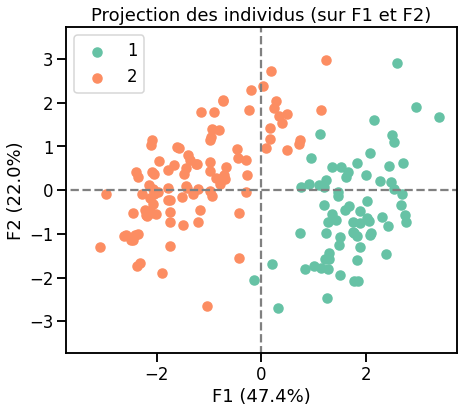

In [ ]:
display_factorial_planes(coord, p, acp, [(0,1)], illustrative_var=illustrative_var)

#### 4.1.3. Analyses descriptives de la classification

In [ ]:
description = data.groupby('cluster').describe().transpose()
print(description)

cluster                      1           2
diagonal     count   71.000000   99.000000
             mean   171.894085  171.973939
             std      0.292836    0.311909
             min    171.380000  171.040000
             25%    171.690000  171.780000
             50%    171.890000  172.010000
             75%    172.045000  172.165000
             max    173.010000  172.750000
height_left  count   71.000000   99.000000
             mean   104.243662  103.939192
             std      0.218679    0.282953
             min    103.780000  103.230000
             25%    104.115000  103.740000
             50%    104.220000  103.910000
             75%    104.385000  104.120000
             max    104.860000  104.650000
height_right count   71.000000   99.000000
             mean   104.160986  103.761111
             std      0.266631    0.265841
             min    103.440000  103.140000
             25%    103.990000  103.555000
             50%    104.170000  103.760000
           

In [ ]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == True][i]
    cluster = data.loc[data['cluster'] == 1][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(genuine, cluster))
    elif i in cols_1:
        print('Test de Bartlett :', st.stats.bartlett(genuine,cluster))
        print('Test de Student :', st.stats.ttest_ind(genuine,cluster, equal_var=True))
    else:
        print('Test de Bartlett :', st.stats.bartlett(genuine,cluster))
        print('Test de Welsch :', st.stats.ttest_ind(genuine,cluster, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.20597584767762156, pvalue=0.6499399452134673)
Test de Student : Ttest_indResult(statistic=1.7510857077916284, pvalue=0.08174546372615159)
Height_left
Test de Bartlett : BartlettResult(statistic=7.157870949376627, pvalue=0.00746357345742929)
Test de Welsch : Ttest_indResult(statistic=-7.418111048899185, pvalue=5.531370725404157e-12)
Height_right
Test de Bartlett : BartlettResult(statistic=0.6858875780787472, pvalue=0.4075667001141948)
Test de Student : Ttest_indResult(statistic=-8.798639174469887, pvalue=1.562392586974314e-15)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=369.0, pvalue=1.0259846057333552e-23)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.27367102662870385, pvalue=0.600879779682454)
Test de Student : Ttest_indResult(statistic=-9.273664200826179, pvalue=8.359423529712947e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=220.5, pvalue=8.505073437751944e-26)


In [ ]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == False][i]
    cluster = data.loc[data['cluster'] == 2][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(genuine, cluster))
    elif i in cols_1:
        print('Test de Bartlett :', st.stats.bartlett(genuine,cluster))
        print('Test de Student :', st.stats.ttest_ind(genuine,cluster, equal_var=True))
    else:
        print('Test de Bartlett :', st.stats.bartlett(genuine,cluster))
        print('Test de Welsch :', st.stats.ttest_ind(genuine,cluster, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.18087559833827596, pvalue=0.6706218425575824)
Test de Student : Ttest_indResult(statistic=-1.7595206277000377, pvalue=0.08032025349319885)
Height_left
Test de Bartlett : BartlettResult(statistic=6.179889994029566, pvalue=0.01292103098077704)
Test de Welsch : Ttest_indResult(statistic=7.628195184209143, pvalue=1.7466995178898618e-12)
Height_right
Test de Bartlett : BartlettResult(statistic=0.1913404797385084, pvalue=0.6618032818783942)
Test de Student : Ttest_indResult(statistic=9.444500713054603, pvalue=3.1262385711790714e-17)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=349.0, pvalue=1.343938528386236e-23)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.2577207307809787, pvalue=0.6116903851013222)
Test de Student : Ttest_indResult(statistic=9.399815165763334, pvalue=4.1277193797224106e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=189.0, pvalue=7.003355554376515e-26)


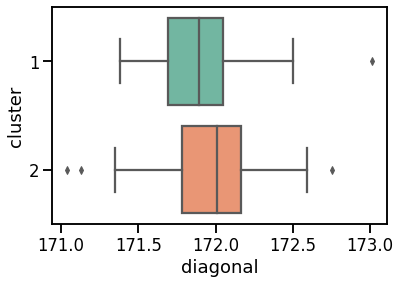

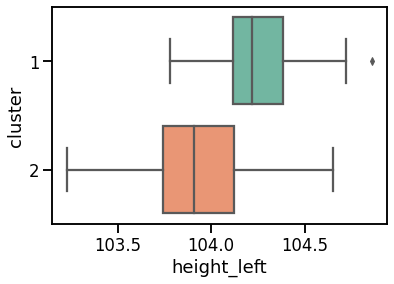

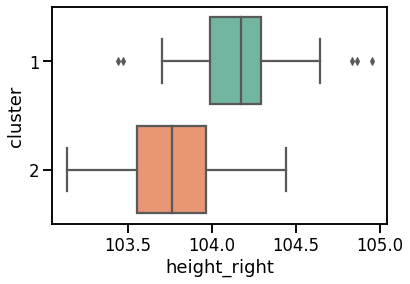

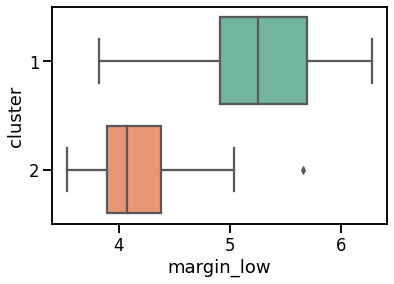

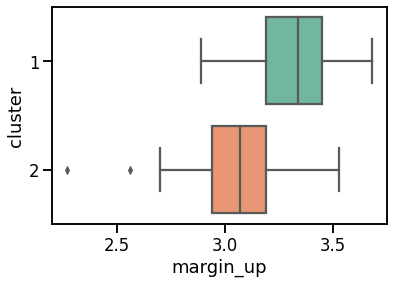

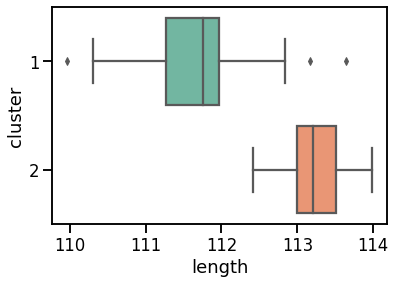

In [ ]:
for i in cols: 
    _ = sns.boxplot(x=i, y='cluster', data=data, orient='h')
    _ = plt.show()

In [ ]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    true = data.loc[data['cluster'] == 1][i]
    false = data.loc[data['cluster'] == 2][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(true, false))
    elif i in cols_1:
        print('Test de Bartlett :', st.stats.bartlett(true,false))
        print('Test de Student :', st.stats.ttest_ind(true,false, equal_var=True))
    else:
        print('Test de Bartlett :', st.stats.bartlett(true,false))
        print('Test de Welsch :', st.stats.ttest_ind(true,false, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.3206957103806736, pvalue=0.5711898481950044)
Test de Student : Ttest_indResult(statistic=-1.6884824741742679, pvalue=0.09317397341329761)
Height_left
Test de Bartlett : BartlettResult(statistic=5.184785738256288, pvalue=0.02278548163154469)
Test de Welsch : Ttest_indResult(statistic=7.908329193946792, pvalue=3.3910152999312346e-13)
Height_right
Test de Bartlett : BartlettResult(statistic=0.000714941140380228, pvalue=0.9786683986376231)
Test de Student : Ttest_indResult(statistic=9.660224307659364, pvalue=7.784663752107234e-18)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=411.5, pvalue=5.441359874851291e-23)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.1934828538491552, pvalue=0.6600335399794182)
Test de Student : Ttest_indResult(statistic=9.37667720595948, pvalue=4.57951873975617e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=183.0, pvalue=3.300956216053636e-26)


In [ ]:
for i in cols:
    print(i.capitalize())
    X = data['cluster'] # qualitative
    Y = data[i] # quantitative
    print('eta-squared :', eta_squared(X,Y))

Diagonal
eta-squared : 0.01668689978430001
Height_left
eta-squared : 0.25507907227898124
Height_right
eta-squared : 0.3571098934633154
Margin_low
eta-squared : 0.5928506899658359
Margin_up
eta-squared : 0.34355018135435744
Length
eta-squared : 0.699025418819586


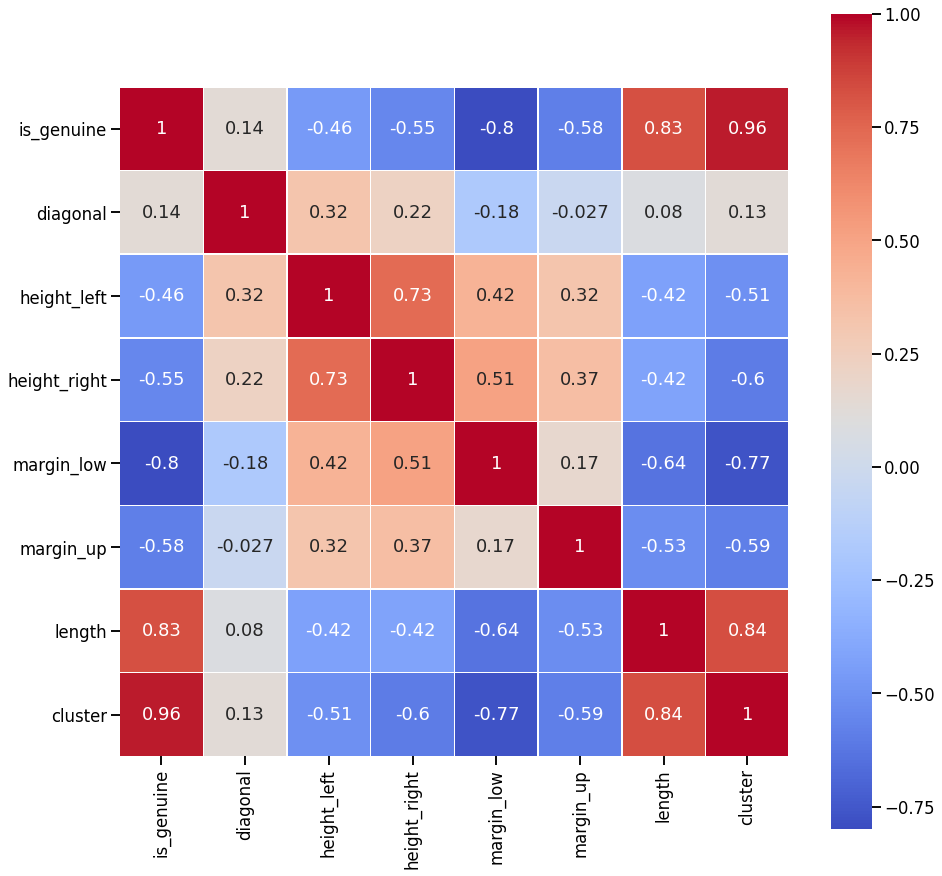

In [ ]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
_ = plt.show()

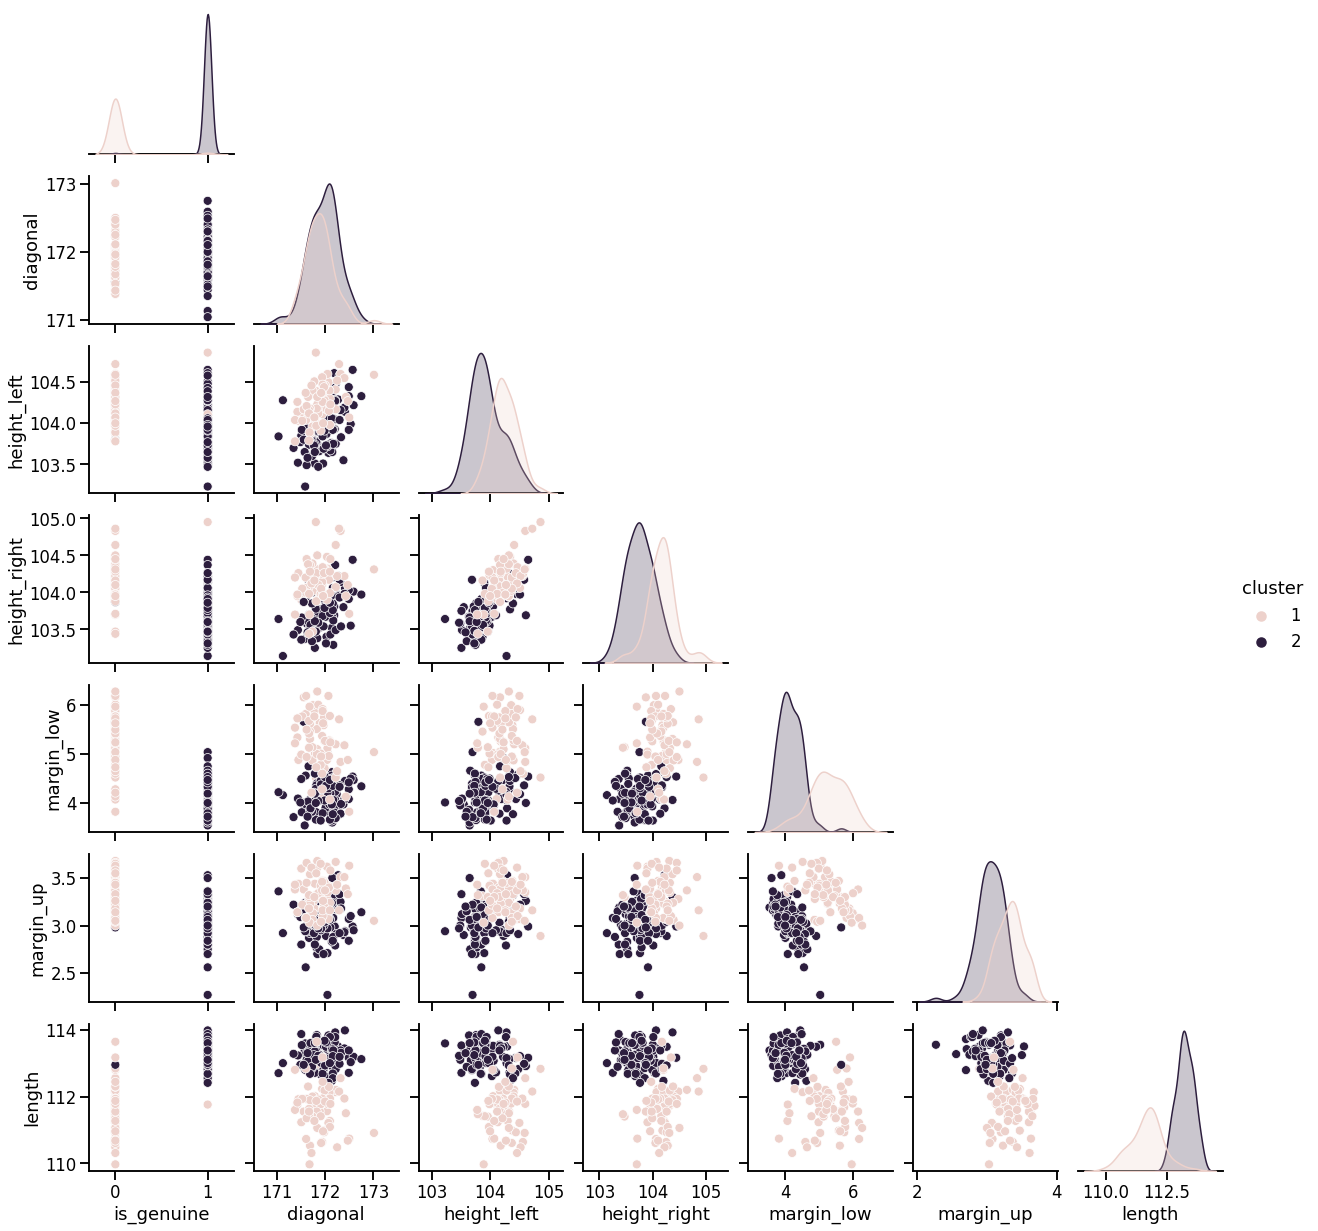

In [ ]:
_ = sns.pairplot(data, hue='cluster', corner=True)
_ = plt.show()

### 4.2. Classification par algorithme KMeans

#### 4.2.1. Construction de l'algorithme

In [ ]:
X = data.values

km = KMeans(n_clusters=2)
km.fit(X)
clustersk = km.labels_

In [ ]:
data_clusterk = pd.DataFrame({'clusters_kmeans' : clustersk})
data = data.join(data_clusterk)
illustrative_var = data['clusters_kmeans']

#### 4.2.2. Représentation graphique dans le premier plan factoriel

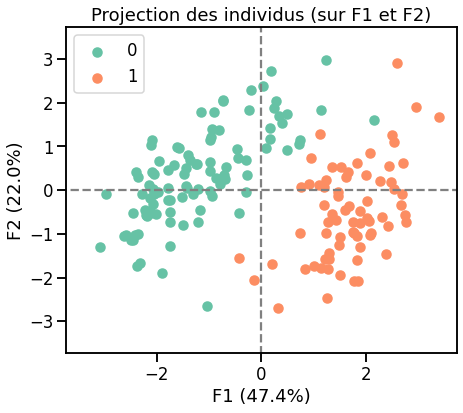

In [ ]:
display_factorial_planes(coord, p, acp, [(0,1)], illustrative_var=illustrative_var)

#### 4.2.3. Analyses descriptives issu de l'algorithme KMeans

In [ ]:
description = data.groupby('clusters_kmeans').describe().transpose()
print(description)

clusters_kmeans              0           1
diagonal     count   99.000000   71.000000
             mean   171.976465  171.890563
             std      0.309527    0.295354
             min    171.040000  171.380000
             25%    171.790000  171.685000
             50%    172.010000  171.890000
             75%    172.165000  172.045000
             max    172.750000  173.010000
height_left  count   99.000000   71.000000
             mean   103.949899  104.228732
             std      0.297323    0.212084
             min    103.230000  103.780000
             25%    103.740000  104.090000
             50%    103.910000  104.210000
             75%    104.150000  104.375000
             max    104.860000  104.720000
height_right count   99.000000   71.000000
             mean   103.772020  104.145775
             std      0.291295    0.251343
             min    103.140000  103.440000
             25%    103.555000  103.985000
             50%    103.760000  104.170000
           

In [ ]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == True][i]
    clusterk = data.loc[data['clusters_kmeans'] == 0][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(genuine, clusterk))
    elif i in cols_1:
        print('Test de Bartlett :', st.stats.bartlett(genuine,clusterk))
        print('Test de Student :', st.stats.ttest_ind(genuine,clusterk, equal_var=True))
    else:
        print('Test de Bartlett :', st.stats.bartlett(genuine,clusterk))
        print('Test de Welsch :', st.stats.ttest_ind(genuine,clusterk, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.0024560019721142604, pvalue=0.9604745634939035)
Test de Student : Ttest_indResult(statistic=-0.00833018874896814, pvalue=0.9933619774649923)
Height_left
Test de Bartlett : BartlettResult(statistic=0.0012798180126682305, pvalue=0.9714621308565733)
Test de Welsch : Ttest_indResult(statistic=0.038048353991925105, pvalue=0.9696876650912427)
Height_right
Test de Bartlett : BartlettResult(statistic=0.0014187690787053776, pvalue=0.9699535453432222)
Test de Student : Ttest_indResult(statistic=0.09376365425016264, pvalue=0.9253921973097893)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=4949.0, pvalue=0.49950883738688523)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.003977817174502813, pvalue=0.9497108120242828)
Test de Student : Ttest_indResult(statistic=0.10645073598588996, pvalue=0.9153330620499752)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=4900.5, pvalue=0.451984273494459)


In [ ]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == False][i]
    clusterk = data.loc[data['clusters_kmeans'] == 1][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(genuine, clusterk))
    elif i in cols_1:
        print('Test de Bartlett :', st.stats.bartlett(genuine,clusterk))
        print('Test de Student :', st.stats.ttest_ind(genuine,clusterk, equal_var=True))
    else:
        print('Test de Bartlett :', st.stats.bartlett(genuine,clusterk))
        print('Test de Welsch :', st.stats.ttest_ind(genuine,clusterk, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.003372734900236268, pvalue=0.9536886871198211)
Test de Student : Ttest_indResult(statistic=-0.014146989293169944, pvalue=0.9887329973245258)
Height_left
Test de Bartlett : BartlettResult(statistic=0.0016692764206281702, pvalue=0.9674100737199126)
Test de Welsch : Ttest_indResult(statistic=0.047364485381957144, pvalue=0.9622907432576605)
Height_right
Test de Bartlett : BartlettResult(statistic=0.0035484527276117782, pvalue=0.9524989960551565)
Test de Student : Ttest_indResult(statistic=-0.004783163148524644, pvalue=0.996190460424989)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=2452.0, pvalue=0.4466879748077497)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.003522349558862779, pvalue=0.9526738264694736)
Test de Student : Ttest_indResult(statistic=-0.006994896553009098, pvalue=0.9944289546709285)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=2484.5, pvalue=0.5)


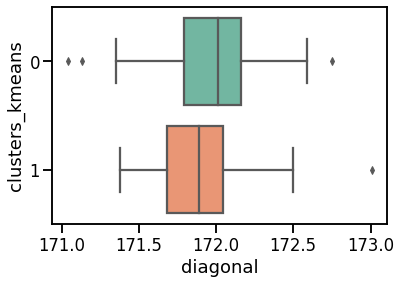

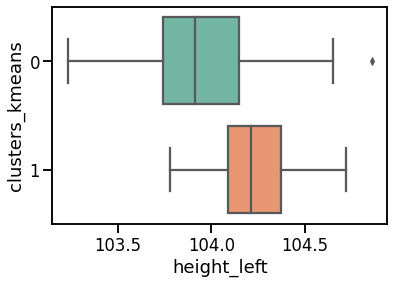

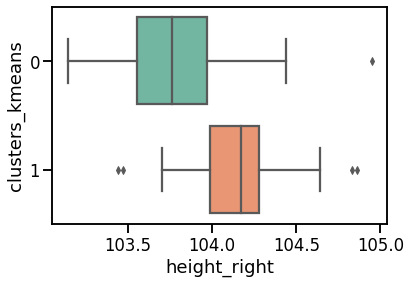

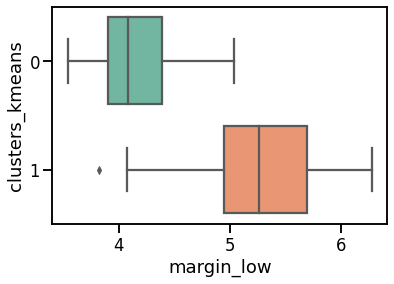

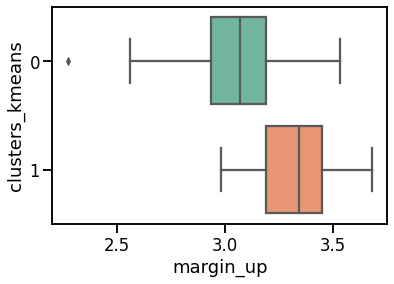

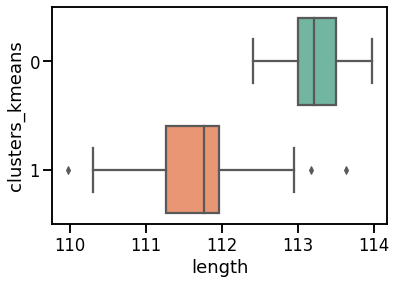

In [ ]:
for i in cols: 
    _ = sns.boxplot(x=i, y='clusters_kmeans', data=data, orient='h')
    _ = plt.show()

In [ ]:
for i in cols:
    print(i.capitalize())
    X = data['clusters_kmeans'] # qualitative
    Y = data[i] # quantitative
    print('eta-squared :', eta_squared(X,Y))

Diagonal
eta-squared : 0.019309533895825372
Height_left
eta-squared : 0.21393176139161454
Height_right
eta-squared : 0.3119798433133232
Margin_low
eta-squared : 0.6231396905742382
Margin_up
eta-squared : 0.34891073616002233
Length
eta-squared : 0.6964312029598763


In [ ]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'height_left', 'margin_up']]

for i in cols:
    true = data.loc[data['clusters_kmeans'] == 0][i]
    false = data.loc[data['clusters_kmeans'] == 1][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', st.stats.mannwhitneyu(true, false))
    elif i in cols_1:
        print('Test de Bartlett :', st.stats.bartlett(true,false))
        print('Test de Student :', st.stats.ttest_ind(true,false, equal_var=True))
    else:
        print('Test de Bartlett :', st.stats.bartlett(true,false))
        print('Test de Welsch :', st.stats.ttest_ind(true,false, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.17731389035949607, pvalue=0.6736918758904122)
Test de Student : Ttest_indResult(statistic=1.8187565046605412, pvalue=0.07072936562292413)
Height_left
Test de Bartlett : BartlettResult(statistic=8.773057405619403, pvalue=0.0030571257246553673)
Test de Student : Ttest_indResult(statistic=-6.761797334986516, pvalue=2.1539234482686791e-10)
Height_right
Test de Bartlett : BartlettResult(statistic=1.7317550813699039, pvalue=0.18818691256572284)
Test de Student : Ttest_indResult(statistic=-8.728052055194281, pvalue=2.4809007875578748e-15)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=354.5, pvalue=8.996485951429831e-24)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.3587022696058316, pvalue=0.549227846511112)
Test de Student : Ttest_indResult(statistic=-9.48836844148114, pvalue=2.2826657785523355e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=190.5, pvalue=4.244323910842022e-26)


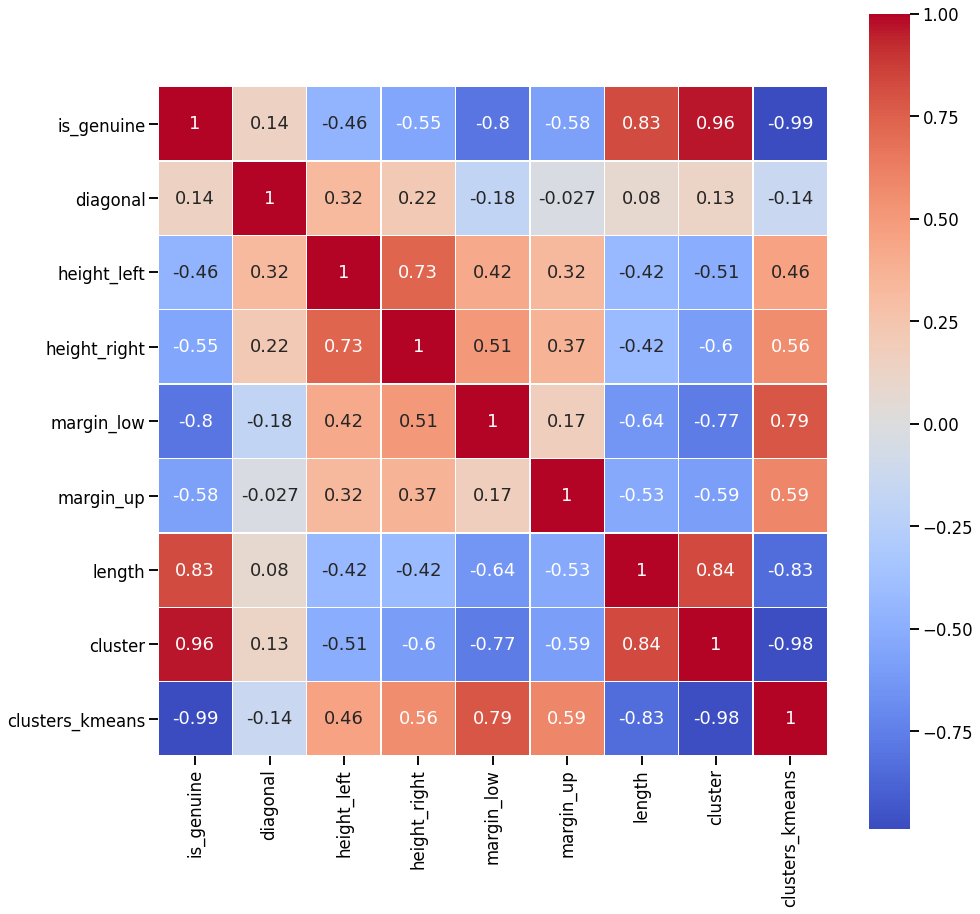

In [ ]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
_ = plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


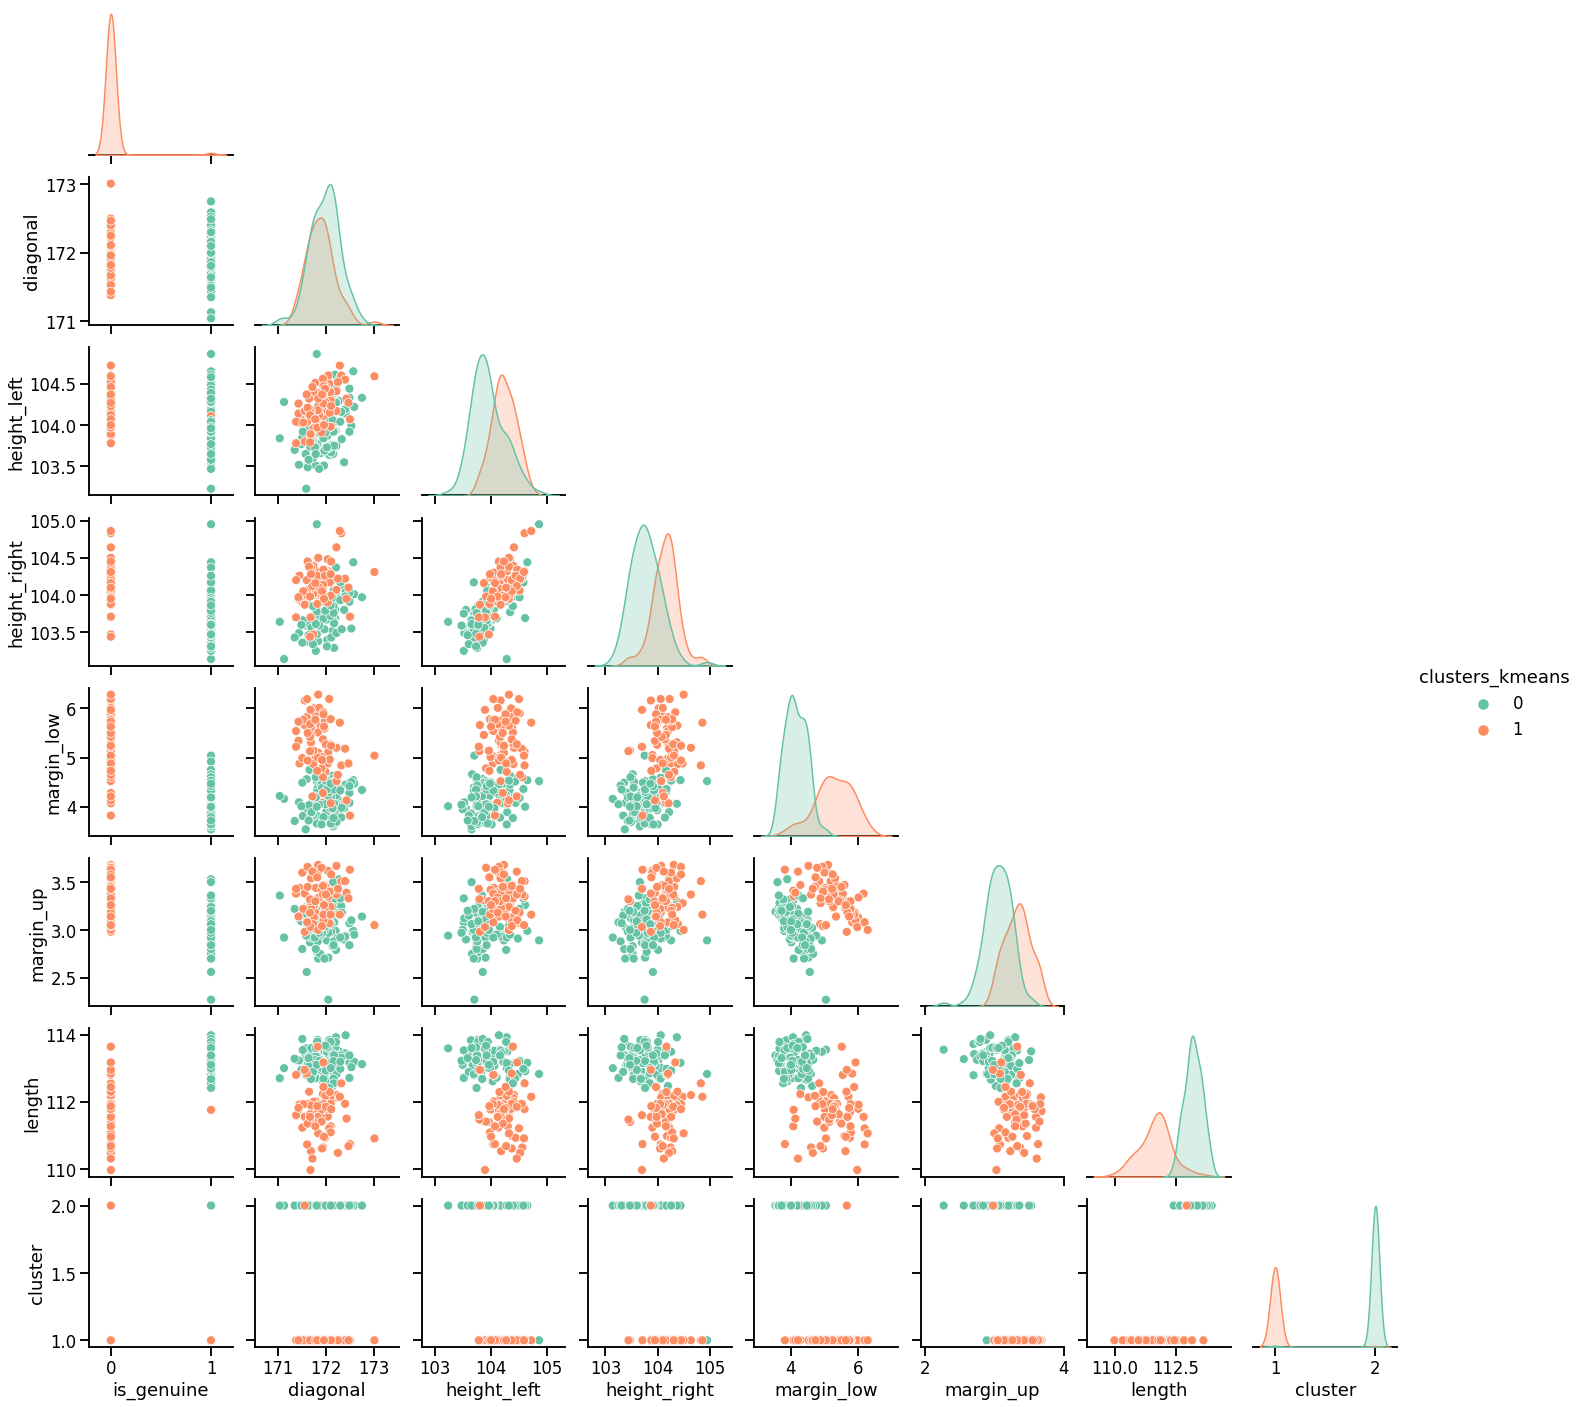

In [ ]:
_ = sns.pairplot(data, hue='clusters_kmeans', corner=True)
_ = plt.show()

## 5. Modélisation : Régression Logistique

**Mission 3** : Modélisez les données à l'aide d'une régression logistique. Grâce à celle-ci, vous créerez un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, votre algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [ ]:
data['is_genuine'] = data['is_genuine'].apply(lambda x: bool(x))
data['is_genuine'] = data['is_genuine'].apply(lambda x: int(x))

L'utilisation des six variables crée un modèle parfait. On va donc enlever une des six variables pour créer notre algorithme de régression logistique. Le choix d'enlever la variable *margin_low* a été fait à l'aide de la matrice de corrélation.

#### 5.1. Entraînement de l'algorithme

In [ ]:
data_copy = data.copy()
train_set = data_copy.sample(frac=0.80, random_state=0)
test_set = data_copy.drop(train_set.index).reset_index()
test_set_labels = test_set.pop('is_genuine')

In [ ]:
reg_log = smf.glm('is_genuine~diagonal+length+margin_up+height_right+height_left',
                   data=train_set, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  136
Model:                            GLM   Df Residuals:                      130
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.836
Date:                Fri, 23 Oct 2020   Deviance:                       33.673
Time:                        13:01:29   Pearson chi2:                     64.7
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -615.5209    306.794     -2.006   

In [ ]:
reg_log = smf.glm('is_genuine~diagonal+length+margin_up',
                   data=train_set, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  136
Model:                            GLM   Df Residuals:                      132
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22.747
Date:                Fri, 23 Oct 2020   Deviance:                       45.493
Time:                        13:01:29   Pearson chi2:                     115.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -900.2938    279.637     -3.220      0.0

In [ ]:
reg_log = smf.glm('is_genuine~length+margin_up',
                   data=train_set, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  136
Model:                            GLM   Df Residuals:                      133
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.072
Date:                Fri, 23 Oct 2020   Deviance:                       50.143
Time:                        13:01:29   Pearson chi2:                     127.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -403.4027     86.838     -4.645      0.0

In [ ]:
beta1 = reg_log.params[0]
beta2 = reg_log.params[1]
beta3 = reg_log.params[2]
print('Beta 1 :' + str(beta1) + ' ; Beta 2 : ' + str(beta2) + ' ; Beta 3 : ' + str(beta3))

Beta 1 :-403.40271892022156 ; Beta 2 : 3.7343431346499116 ; Beta 3 : -5.220857579098483


In [ ]:
test_set_data = test_set[['length', 'margin_up']]
predict = reg_log.predict(test_set_data)

prediction=pd.DataFrame({'id': test_set['index'],
                         'prediction' : predict.values})
prediction['is_genuine_pred'] = prediction['prediction'].apply(lambda x: True if (x >= 0.5) else False)
print(prediction)

     id  prediction  is_genuine_pred
0     9    0.696749             True
1    21    0.958811             True
2    25    0.991714             True
3    28    0.969583             True
4    29    0.999232             True
5    31    0.999147             True
6    32    0.626992             True
7    36    0.992783             True
8    39    0.965549             True
9    47    0.974837             True
10   58    0.829332             True
11   67    0.994866             True
12   70    0.478930            False
13   72    0.904071             True
14   77    0.674483             True
15   79    0.993304             True
16   81    0.777406             True
17   82    0.993043             True
18   87    0.992350             True
19   88    0.831476             True
20   99    0.964047             True
21  103    0.151800            False
22  114    0.091461            False
23  115    0.008817            False
24  117    0.092643            False
25  127    0.023996            False
2

#### 5.2. Test de l'algorithme

In [ ]:
prediction['is_genuine_labels'] = test_set_labels.apply(lambda x:bool(x))

### 5.3. Evaluation du modèle

In [ ]:
data_2 = {'y_actual' : np.array(prediction['is_genuine_labels']),
        'y_predicted' : np.array(prediction['is_genuine_pred'])}

df = pd.DataFrame(data_2, columns=['y_actual','y_predicted'])

confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])

print(confusion_matrix)

Predicted  False  True 
Actual                 
False         13      0
True           1     20


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df['y_actual'], df['y_predicted'])

0.9761904761904762

## Utillisation : Script de l'algorithme sur un nouveau jeu de données

In [ ]:
reg_log = smf.glm('is_genuine~+length+margin_up',
                   data=data, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                            GLM   Df Residuals:                      167
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.906
Date:                Fri, 23 Oct 2020   Deviance:                       57.812
Time:                        13:01:30   Pearson chi2:                     178.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -445.5575     86.940     -5.125      0.0

In [ ]:
# Chargement d'un nouveau dataset
data_test = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P6_guillot_cecile/example.csv')

In [ ]:
test_set_data = data_test[['length', 'margin_up']]
predict = reg_log.predict(test_set_data)

prediction=pd.DataFrame({'id': data_test.index,
                         'prediction' : predict.values})
prediction['is_genuine_pred'] = prediction['prediction'].apply(lambda x: True if (x >= 0.5) else False)
print(prediction)

   id  prediction  is_genuine_pred
0   0    0.007813            False
1   1    0.105010            False
2   2    0.009052            False
3   3    0.979666             True
4   4    0.976639             True
